# Random Forest

In random forests, each tree in the ensemble is built from a **sample drawn with replacement** (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a **random subset of the features**. 

As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.


## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("data/trainRF.csv")
test = pd.read_csv("data/testRF.csv")

In [3]:
train_13 = train.drop(['day','month', 'duration'], axis = 1)
test_13 = test.drop(['day','month', 'duration'], axis = 1)

In [4]:
from sklearn import preprocessing
categorical_variables =train_13.dtypes[train_13.dtypes=="object"].index.tolist()

In [5]:
for i in categorical_variables:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_13[i]))
    train_13[i] = lbl.transform(train_13[i])
    test_13[i] = lbl.transform(test_13[i])

In [6]:
train_13_data = train_13.ix[:,0:13]
train_13_target = train_13.iloc[:, -1]

In [7]:
test_13_data = train_13.ix[:,0:13]
test_13_target = train_13.iloc[:, -1]

## Implementing Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
clf = RandomForestClassifier()

In [10]:
clf.fit(train_13_data, train_13_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Key input parameters (in addition to decision trees)
- **bootstrap**: Whether bootstrap samples are used when building trees
- **max_features**: The number of features to consider when looking for the best split (auto = sqrt) 
- **n_estimators**: The number of trees in the forest
- **oob_score**: Whether to use out-of-bag samples to estimate the generalization accuracy

#### Key output parameters 

- **Feature Importance**: The higher, the more important the feature
- **Out-of-Bag Score**: Validation score of the training dataset obtained using an out-of-bag estimate.


## Feature Importance

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The **expected fraction of the samples they contribute to** can thus be used as an estimate of the relative importance of the features.

By averaging those expected activity rates over random trees one can reduce the variance of such an estimate and use it for feature selection.

In [11]:
importances = clf.feature_importances_

In [12]:
# Importance of the features in the forest
importances

array([ 0.21747118,  0.0857483 ,  0.02850155,  0.03935648,  0.00305966,
        0.31766061,  0.02718623,  0.01154792,  0.02440918,  0.07669358,
        0.07025115,  0.03328165,  0.06483251])

In [13]:
#Calculate the standard deviation of variable importance
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [14]:
std

array([ 0.01340944,  0.01034965,  0.00532252,  0.00854906,  0.0007119 ,
        0.01433815,  0.01110562,  0.00270363,  0.00317038,  0.00817663,
        0.01114424,  0.01279268,  0.01121143])

In [15]:
indices = np.argsort(importances)[::-1]
indices

array([ 5,  0,  1,  9, 10, 12,  3, 11,  2,  6,  8,  7,  4])

In [16]:
length = train_13_data.shape[1]

In [17]:
labels = []

In [18]:
for i in range(length):
    labels.append(train_13_data.columns[indices[i]])

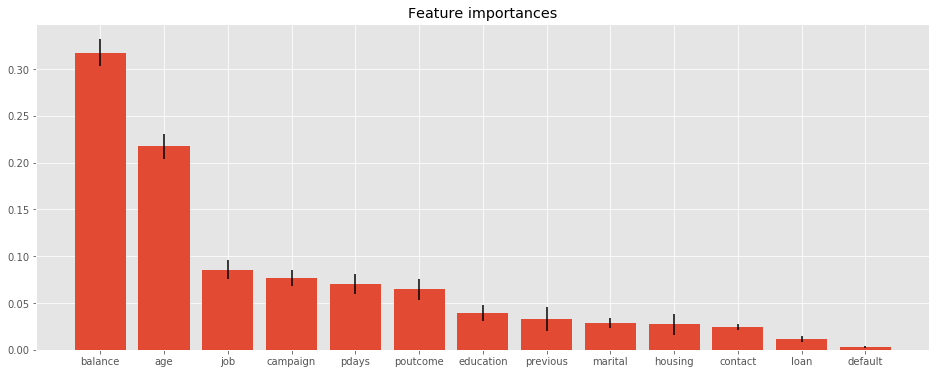

In [19]:
# Plot the feature importances of the forest
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(length), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(length), labels)
plt.xlim([-1, length])
plt.show()

## Out-of-Bag Error
The out-of-bag (OOB) error is the average error for each training observation calculated using predictions from the trees that do not contain it in their respective bootstrap sample. This allows the RandomForest to be fit and validated whilst being trained.

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
clf2 = RandomForestClassifier(warm_start=True, oob_score=True, max_features=None)

In [22]:
clf2.fit(train_13_data, train_13_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=True)

In [23]:
clf2.oob_score_

0.8645309704353753

In [24]:
min_estimators = 10
max_estimators = 50
error_rate = []

In [25]:
for i in range(min_estimators, max_estimators + 1):
    clf2.set_params(n_estimators=i)
    clf2.fit(train_13_data, train_13_target)
    oob_error = 1 - clf2.oob_score_
    error_rate.append(oob_error)

In [26]:
error_rate_indice = [x for x in range(min_estimators, max_estimators + 1)]

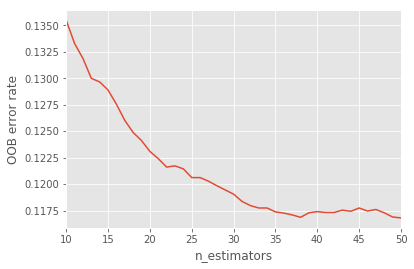

In [27]:
plt.figure()
plt.plot(error_rate_indice, error_rate)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()